In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

# Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드 받아 한영 병렬 데이터를 확보합니다.

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [3]:
import os

folder_path = os.getenv('HOME')+'/aiffel/s2s_translation/'

In [4]:
kor_data_path = folder_path + 'korean-english-park.train.ko'
en_data_path  = folder_path + 'korean-english-park.train.en'

In [5]:
with open(kor_data_path, "r") as f:
    kor_data = f.read().splitlines()

    
with open(en_data_path, "r") as f:
    en_data = f.read().splitlines()

In [6]:
print("Data Size:", len(kor_data))
print("Example:")
for sen in kor_data[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [7]:
print("Data Size:", len(en_data))
print("Example:")
for sen in en_data[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

In [8]:
cleaned_corpus = set(zip(kor_data,en_data))

In [9]:
cleaned_corpus

{('더 내이션 미디어 그룹(The Nation Media group)은 아가칸에 의해 지난 1960대에 설립됐다. 지금은 수많은 신문과 잡지, 라디오, TV 프로그램을 영어와 스와힐리어로 발행 또는 내보내고 있다.',
  'The Nation Media group was founded by the Aga Khan in 1960 and now has a growing number of newspapers, magazines, and radio and television stations in English and Kiswahili.'),
 ('범인은 경찰관 1명과 민간인 1명을 살해하고 2명에게 부상을 입힌 뒤 스스로 목숨을 끊은 것으로 알려졌다.',
  'The gunman killed a police officer and a civilian and wounded two others before apparently turning the gun on himself, authorities said.'),
 ('The Changeling)’가 촬영 중인 촬영소가 피해를 입었다”고 밝혔다.',
  'Another area, called "Courthouse Square," also was destroyed, Meyer said.'),
 ('범인이 처음 석방한 인질은 아이를 동반한 한 여성이었다.',
  'A woman with a baby was released by the hostage-taker early on, she told a witness, Lettie Tzizik, who spoke to WMUR.'),
 ('에이디는 경매로 2만6000파운드(약 4800만원)라는 싼 값에 피아노를 구입했다.',
  '26,000 ($51,410), but this was considered a bargain.'),
 ('35세의 이 여성은 서울에서 부산으로 가는 비행기 안에서 승무원의 제지를 무시하면서 회사 동료와 약 5분 간 통화를 계속했다.',
  'Another p

In [10]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = mecab.morphs(sentence)
    
    return sentence

In [11]:
def preprocess_sentence_en(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

In [12]:
from konlpy.tag import Mecab

In [13]:
kor_corpus = []
en_corpus = []

for i in cleaned_corpus:
    temp_kor = preprocess_sentence_ko(i[0])
    temp_en  = preprocess_sentence_en(i[1])
    if (len(temp_kor) <= 30) & (len(temp_en) <= 30):
        kor_corpus.append(temp_kor)
        en_corpus.append(temp_en)

In [14]:
kor_corpus

[['범인',
  '은',
  '경찰관',
  '명과',
  '민간',
  '인',
  '명',
  '을',
  '살해',
  '하',
  '고',
  '명',
  '에게',
  '부상',
  '을',
  '입힌',
  '뒤',
  '스스로',
  '목숨',
  '을',
  '끊',
  '은',
  '것',
  '으로',
  '알려졌',
  '다',
  '.'],
 ['가',
  '촬영',
  '중',
  '인',
  '촬영소',
  '가',
  '피해',
  '를',
  '입',
  '었',
  '다',
  '고',
  '밝혔',
  '다',
  '.'],
 ['범인',
  '이',
  '처음',
  '석방',
  '한',
  '인질',
  '은',
  '아이',
  '를',
  '동반',
  '한',
  '한',
  '여성',
  '이',
  '었',
  '다',
  '.'],
 ['에이디',
  '는',
  '경매',
  '로',
  '만',
  '파운드',
  '약',
  '만',
  '원',
  '라는',
  '싼',
  '값',
  '에',
  '피아노',
  '를',
  '구입',
  '했',
  '다',
  '.'],
 ['한편',
  '중국',
  '은',
  '북한',
  '당국',
  '이',
  '제시',
  '한',
  '신',
  '고서',
  '를',
  '받',
  '은',
  '뒤',
  '이',
  '자료',
  '를',
  '미',
  '국무부',
  '에',
  '넘기',
  '기',
  '로',
  '했',
  '다',
  '.'],
 ['금년',
  '드래프트',
  '에서',
  '첫',
  '번',
  '째',
  '선택',
  '은',
  '틀림없이',
  '피트',
  '인치',
  '의',
  '중국인',
  '선수',
  '야오',
  '밍',
  '이',
  '될',
  '것',
  '이',
  '다',
  '.'],
 ['이번',
  '집회',
  '는',
  '하마스',
  '가',
  '가자지구',
  

In [15]:
en_corpus

[['<start>',
  'the',
  'gunman',
  'killed',
  'a',
  'police',
  'officer',
  'and',
  'a',
  'civilian',
  'and',
  'wounded',
  'two',
  'others',
  'before',
  'apparently',
  'turning',
  'the',
  'gun',
  'on',
  'himself',
  ',',
  'authorities',
  'said',
  '.',
  '<end>'],
 ['<start>',
  'another',
  'area',
  ',',
  'called',
  'courthouse',
  'square',
  ',',
  'also',
  'was',
  'destroyed',
  ',',
  'meyer',
  'said',
  '.',
  '<end>'],
 ['<start>',
  'a',
  'woman',
  'with',
  'a',
  'baby',
  'was',
  'released',
  'by',
  'the',
  'hostage',
  'taker',
  'early',
  'on',
  ',',
  'she',
  'told',
  'a',
  'witness',
  ',',
  'lettie',
  'tzizik',
  ',',
  'who',
  'spoke',
  'to',
  'wmur',
  '.',
  '<end>'],
 ['<start>',
  ',',
  ',',
  ',',
  'but',
  'this',
  'was',
  'considered',
  'a',
  'bargain',
  '.',
  '<end>'],
 ['<start>',
  'they',
  'are',
  'expected',
  'to',
  'hand',
  'over',
  'a',
  'declaration',
  'on',
  'the',
  'plutonium',
  'activities',


# Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다

In [16]:
from sklearn.model_selection import train_test_split

In [19]:
def tokenize(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 10000,filters='')
    
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [20]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(en_corpus)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 28957
English Vocab Size: 29404


# Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [24]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 29405)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [26]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

## 예문 ##
K1) 오바마는 대통령이다.  
K2) 시민들은 도시 속에 산다.  
K3) 커피는 필요 없다.  
K4) 일곱 명의 사망자가 발생했다.  

## 제출 ##
E1) obama is the president . <end>  
E2) people are victims of the city . <end>  
E2) the price is not enough . <end>  
E2) seven people have died . <end>  

In [27]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 508/508 [03:23<00:00,  2.50it/s, Loss 2.6291]


In [28]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 127/127 [00:12<00:00, 10.50it/s, Test Loss 3.3136]


In [47]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama s remarks . <end> 


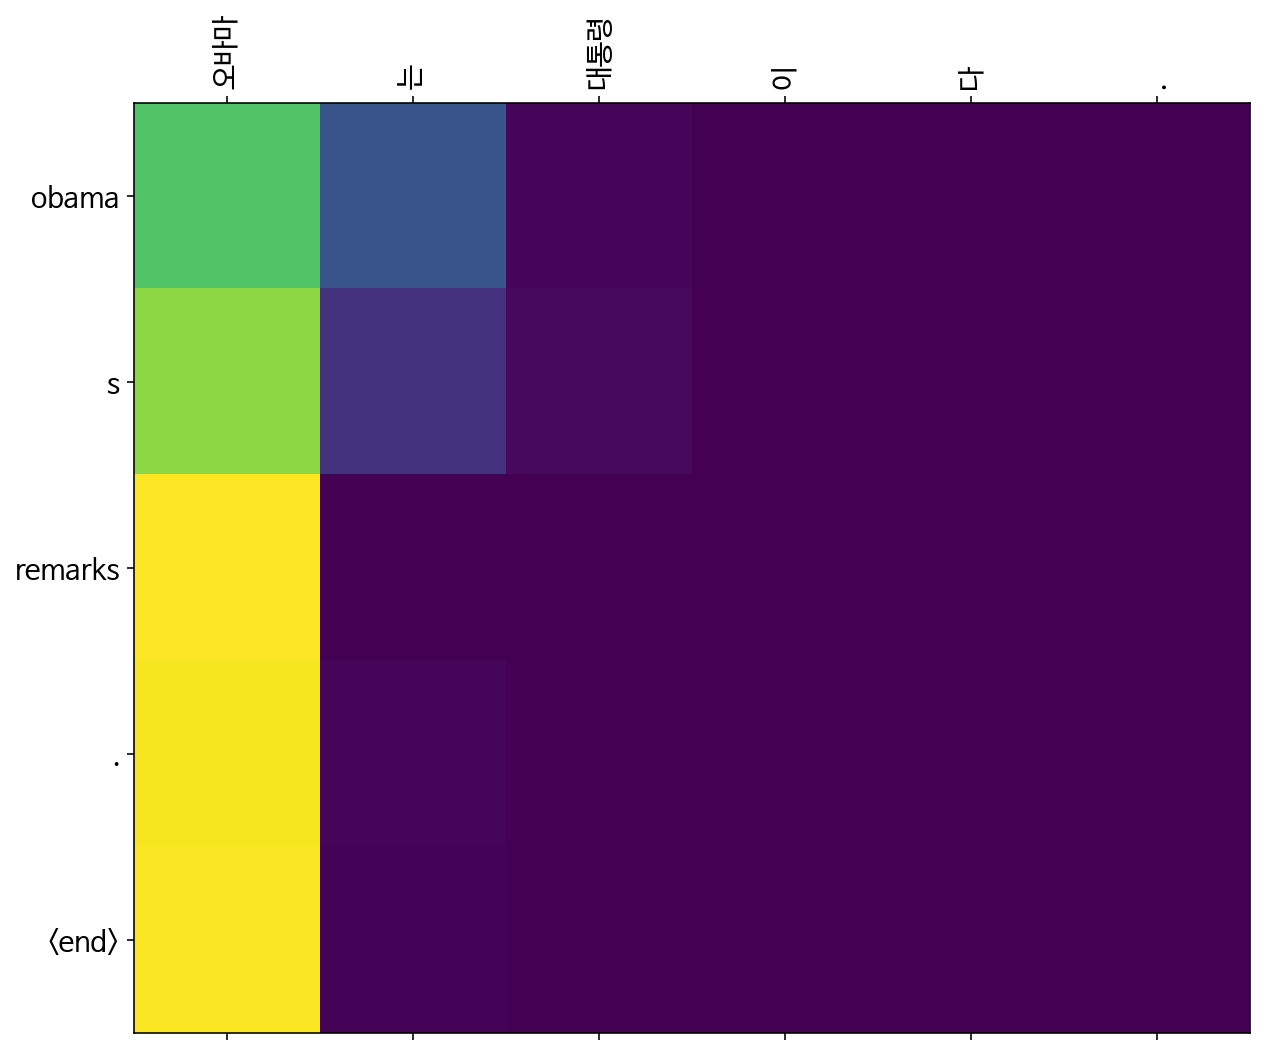

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the alleged abuse of the alleged abuse of the alleged abuse of the alleged abuse of the alleged abuse of the alleged abuse of the alleged abuse of the alleged 


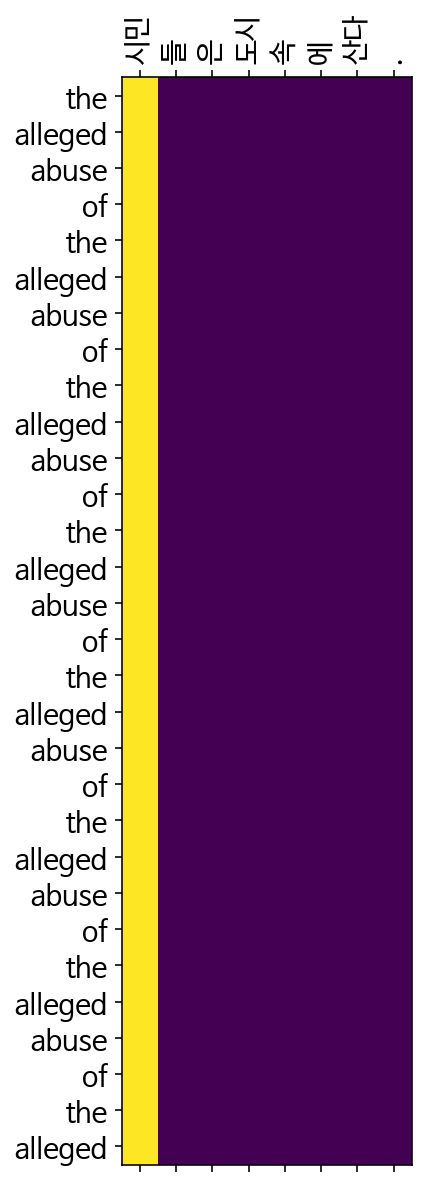

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the referee no chance for the referee no chance for the referee no chance for the referee no chance for the referee no chance for the referee no chance for 


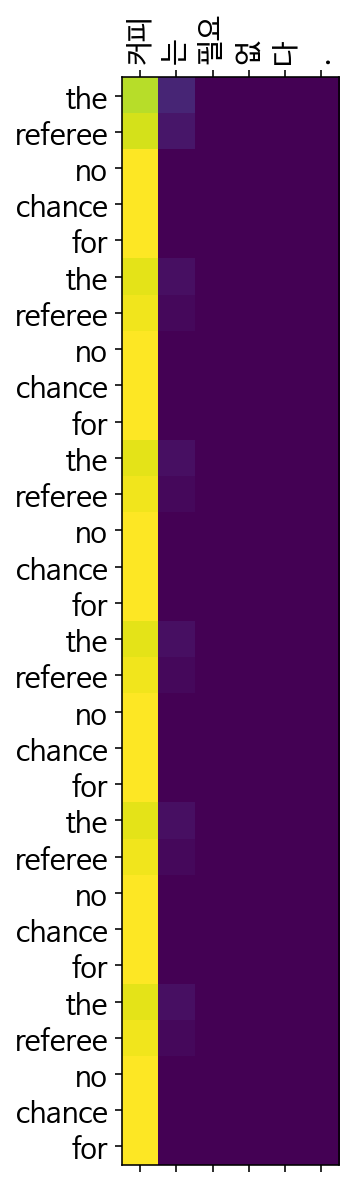

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the biggest threats in the biggest threats in the biggest threats in the biggest threats in the biggest threats in the biggest threats in the biggest threats in the biggest 


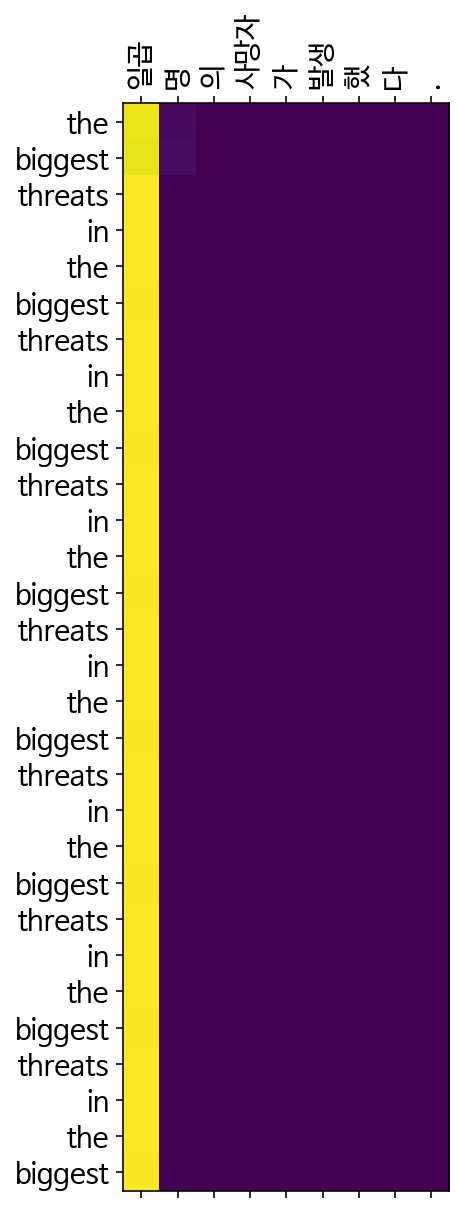

In [50]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)